In [1]:
import cPickle as pickle
import pandas as pd
import numpy as np
import random 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib
%matplotlib inline

/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
def prep(df):

    # A few columns have to go for us to build a model (though we use them for user presentation)
    df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
             'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

    # create dummy variables for formations
    form_dummies = pd.get_dummies(df.Formation)
    form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

    # create dummy variables for teams
    team_dummies = pd.get_dummies(df.OffenseTeam)
    team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

    # combine the dummy variables and drop the categorical versions
    df_prepped = pd.concat(
        [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        team_dummies,
        form_dummies], axis=1)

    return df_prepped

In [7]:
def combine(filenames):

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))

    df = pd.concat(dfs)

    return df

In [8]:
def plot_confusion_matrix(cm):
    '''Code stolen brazenly from sklearn example.'''
    print(cm)

    # Show confusion matrix in a separate window
    plt.matshow(cm)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Split off a validation set for the users and models to compete over

In [137]:
# read in the cleaned data, combine it, but leave it without dummies
filenames = ['data/pbp2016-clean.csv', 'data/pbp2015-clean.csv', 'data/pbp2014-clean.csv', 'data/pbp2013-clean.csv']
pbp_raw = combine(filenames)

In [138]:
pbp_train, pbp_validation = train_test_split(pbp_raw, test_size = 0.1, random_state=22) # 10% is about 13.5k plays

In [139]:
pbp_train.to_csv('data/pbp-training.csv', index=False)

In [140]:
pbp_validation.to_csv('data/pbp-validation.csv', index=False)

In [141]:
print 'training set:  ', pbp_train.shape
print 'validation set:', pbp_validation.shape

training set:   (121498, 17)
validation set: (13500, 17)


## Prep the training set

In [9]:
pbp_train_raw = pd.read_csv('data/pbp-training.csv')

In [143]:
pbp = prep(pbp_train_raw.copy())

In [144]:
# split the class from the values
y = pbp['Play']
X = pbp.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

### Basic Model Using All Seasons and All Teams

In [145]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [146]:
gbc.score(X_test, y_test)

0.76628806584362141

[[ 2835     4     9]
 [   17 13401  3521]
 [    2  3546  7040]]


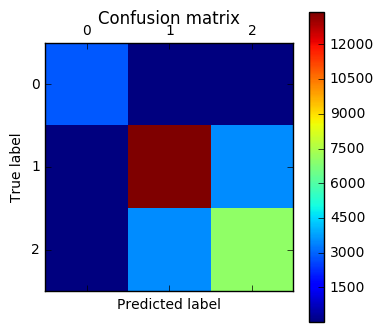

In [147]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

In [148]:
# save the model
with open('data/gbc-v3.pkl', 'w') as f:
    pickle.dump(gbc, f)

### Try putting in the season

In [34]:
df16 = pd.read_csv('data/pbp2016-clean.csv')
df15 = pd.read_csv('data/pbp2015-clean.csv')
df14 = pd.read_csv('data/pbp2014-clean.csv')
df13 = pd.read_csv('data/pbp2013-clean.csv')

In [35]:
df16['Season'] = 2016
df15['Season'] = 2015
df14['Season'] = 2014
df13['Season'] = 2013

In [36]:
df = pd.concat([df16, df15, df14, df13])

In [37]:
df_prepped = prep(df)

In [38]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [39]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [40]:
gbc.score(X_test, y_test)

0.76352592592592594

[[ 3150     3    12]
 [    6 14807  3999]
 [    7  3954  7812]]


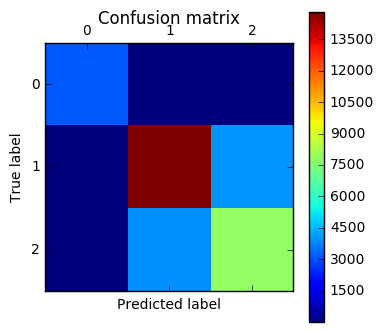

In [41]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Tried this experiment without the 2016 data and it seems to make things worse

### Try losing the offense

In [42]:
df = pbp_train_raw.copy()

In [43]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [44]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,1,7,30,1,10,31,PASS,0,0,0,0,0,1,0
1,3,7,10,2,7,90,PASS,0,0,0,0,1,0,0
2,4,4,53,4,21,59,KICK,0,0,0,1,0,0,0
3,4,5,30,1,1,99,RUSH,0,0,0,0,0,1,0
4,3,7,20,3,5,75,PASS,0,0,1,0,0,0,0


In [45]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [46]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [47]:
gbc.score(X_test, y_test)

0.76651851851851849

[[ 2866     1     5]
 [   15 13367  3489]
 [    6  3576  7050]]


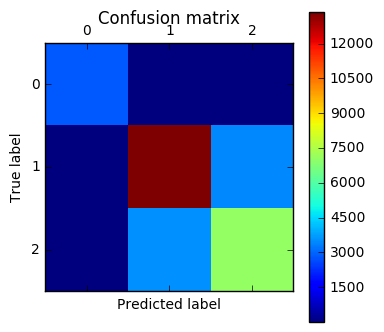

In [48]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight decline here; this should still be suitable for a prior "conventional wisdom" model

### Try keeping the defense in

In [149]:
df = pbp_train_raw.copy()

In [150]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for offensive teams
off_team_dummies = pd.get_dummies(df.OffenseTeam)
off_team_dummies.columns = map(lambda x: 'OFF_' + str(x), off_team_dummies.columns)

# create dummy variables for offensive teams
def_team_dummies = pd.get_dummies(df.DefenseTeam)
def_team_dummies.columns = map(lambda x: 'DEF_' + str(x), def_team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    off_team_dummies,
    def_team_dummies,
    form_dummies], axis=1)

In [151]:
df_prepped.columns

Index([u'Quarter', u'Minute', u'Second', u'Down', u'ToGo', u'YardLine',
       u'Play', u'OFF_ARI', u'OFF_ATL', u'OFF_BAL', u'OFF_BUF', u'OFF_CAR',
       u'OFF_CHI', u'OFF_CIN', u'OFF_CLE', u'OFF_DAL', u'OFF_DEN', u'OFF_DET',
       u'OFF_GB', u'OFF_HOU', u'OFF_IND', u'OFF_JAX', u'OFF_KC', u'OFF_LA',
       u'OFF_MIA', u'OFF_MIN', u'OFF_NE', u'OFF_NO', u'OFF_NYG', u'OFF_NYJ',
       u'OFF_OAK', u'OFF_PHI', u'OFF_PIT', u'OFF_SD', u'OFF_SEA', u'OFF_SF',
       u'OFF_TB', u'OFF_TEN', u'OFF_WAS', u'DEF_ARI', u'DEF_ATL', u'DEF_BAL',
       u'DEF_BUF', u'DEF_CAR', u'DEF_CHI', u'DEF_CIN', u'DEF_CLE', u'DEF_DAL',
       u'DEF_DEN', u'DEF_DET', u'DEF_GB', u'DEF_HOU', u'DEF_IND', u'DEF_JAX',
       u'DEF_KC', u'DEF_LA', u'DEF_MIA', u'DEF_MIN', u'DEF_NE', u'DEF_NO',
       u'DEF_NYG', u'DEF_NYJ', u'DEF_OAK', u'DEF_PHI', u'DEF_PIT', u'DEF_SD',
       u'DEF_SEA', u'DEF_SF', u'DEF_TB', u'DEF_TEN', u'DEF_WAS',
       u'FORMATION_FIELD_GOAL', u'FORMATION_NO_HUDDLE',
       u'FORMATION_NO_HUDDLE_SHOTG

In [152]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [153]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [154]:
gbc.score(X_test, y_test)

0.76678189300411526

[[ 2835     4     9]
 [   17 13417  3505]
 [    2  3547  7039]]


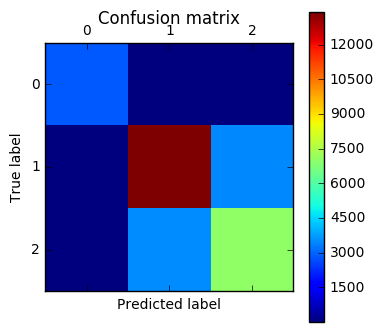

In [155]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Very slight lift from using the defense; not enough to worry about

### Try using the no-offense model as a prior for another team-based model

#### Train a no-offense model

In [156]:
df = pbp_train_raw.copy()

In [157]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_prepped = pd.concat(
    [df.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
    form_dummies], axis=1)

In [158]:
df_prepped.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play,FORMATION_FIELD_GOAL,FORMATION_NO_HUDDLE,FORMATION_NO_HUDDLE_SHOTGUN,FORMATION_PUNT,FORMATION_SHOTGUN,FORMATION_UNDER_CENTER,FORMATION_WILDCAT
0,3,4,8,1,10,46,PASS,0,0,0,0,0,1,0
1,3,6,3,1,10,31,PASS,0,0,0,0,0,1,0
2,2,11,40,1,10,20,PASS,0,0,0,0,0,1,0
3,3,8,8,1,10,17,RUSH,0,0,0,0,1,0,0
4,1,7,3,4,4,24,KICK,0,0,0,1,0,0,0


In [159]:
# split the class from the values
y = df_prepped['Play']
X = df_prepped.drop(['Play'], axis=1).values

In [160]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [161]:
def get_probas(record):
    
    '''
    This takes a dataframe and puts it in the format the conventional wisdom model expects.
    '''

    formations = [
    'FIELD_GOAL',
    'NO_HUDDLE',
    'NO_HUDDLE_SHOTGUN',
    'PUNT',
    'SHOTGUN',
    'UNDER_CENTER',
    'WILDCAT']


    # Dummy the formation
    df1 = pd.get_dummies(record.Formation)
    dummies_frame = pd.get_dummies(formations)
    df1 = df1.reindex(columns=dummies_frame.columns, fill_value=0)
    df1.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), df1.columns)

    # Combine the dummy variables and drop the categorical versions
    record = pd.concat(
        [record.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'Play']],
        df1], axis=1)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [162]:
df_new = pbp_train_raw.copy()

In [163]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [164]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([  3.35305816e-04,   8.05174560e-01,   1.94490134e-01])

#### apply it to the whole dataframe

In [165]:
probas = get_probas(df_new)

In [166]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [167]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Quarter                                                              1
Minute                                                              11
Second                                                              29
OffenseTeam                                                        IND
DefenseTeam                                                        ATL
Down                                                                 2
ToGo                                                                 6
YardLine                                                            54
Description          (11:29) (SHOTGUN) 23-F.GORE RIGHT GUARD TO ATL...
Yards                                                                0
Formation                                                      SHOTGUN
PlayType                                                          RUSH
PassType                                                           NaN
RushDirection                                              RIGHT GUARD
YardLi

#### now, dummy out the teams and formations and train a new model

In [168]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [169]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [170]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [171]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [172]:
gbc.score(X_test, y_test)

0.76839506172839511

[[ 2836     4     8]
 [   17 13458  3464]
 [    2  3540  7046]]


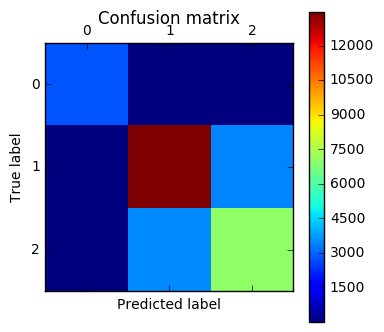

In [173]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### This shows a .15% improvement, which is nominal.  Formation went into the prior model... it probably shouldn't have, since that decision is offense-specific.

### Try again, but leave formation out of the prior model.

In [174]:
df = pbp_train_raw.copy()

In [175]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation'], axis=1, inplace=True)

In [176]:
df.head()

,Quarter,Minute,Second,Down,ToGo,YardLine,Play
0,3,4,8,1,10,46,PASS
1,3,6,3,1,10,31,PASS
2,2,11,40,1,10,20,PASS
3,3,8,8,1,10,17,RUSH
4,1,7,3,4,4,24,KICK


In [177]:
# split the class from the values
y = df['Play']
X = df.drop(['Play'], axis=1).values

In [178]:
# gradient boosting classifier
gbc_cw = GradientBoostingClassifier()
gbc_cw.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

#### we want to add 3 columns to the original dataframe: PROB_PASS, PROB_RUSH, PROB_KICK

In [179]:
def get_probas(record):
    
    # A few columns have to go for us to build a model (though we use them for user presentation)
    record.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam', 'OffenseTeam', \
         'Formation'], axis=1, inplace=True)
    
    # split the class from the values and run it through the model
    return gbc_cw.predict_proba(record.drop(['Play'], axis=1).values)

#### try out the procedure on one record

In [180]:
df_new = pbp_train_raw.copy()

In [181]:
# pick a random play out of the data
rand_play = pd.DataFrame(df_new.iloc[random.randint(0,df_new.shape[0])]).T

In [182]:
get_probas(rand_play)[0] # [kick, pass, rush]

array([ 0.00119482,  0.50972893,  0.48907625])

#### apply it to the whole dataframe

In [183]:
probas = get_probas(df_new.copy())

In [184]:
df_new['PROB_KICK'] = probas[:,0]
df_new['PROB_PASS'] = probas[:,1]
df_new['PROB_RUSH'] = probas[:,2]

In [185]:
df_new.iloc[random.randint(0,df_new.shape[0])]

Quarter                                                              2
Minute                                                               5
Second                                                              55
OffenseTeam                                                        ARI
DefenseTeam                                                        DET
Down                                                                 1
ToGo                                                                10
YardLine                                                            30
Description          (5:55) (SHOTGUN) 5-D.STANTON PASS INCOMPLETE D...
Yards                                                                0
Formation                                                      SHOTGUN
PlayType                                                          PASS
PassType                                                     DEEP LEFT
RushDirection                                                      NaN
YardLi

#### now, dummy out the teams and formations and train a new model

In [186]:
# A few columns have to go for us to build a model (though we use them for user presentation)
df_new.drop(['YardLineFixed', 'YardLineDirection','Description', 'PlayType', \
         'PassType', 'RushDirection', 'Yards', 'DefenseTeam'], axis=1, inplace=True)

# create dummy variables for formations
form_dummies = pd.get_dummies(df_new.Formation)
form_dummies.columns = map(lambda x: 'FORMATION_' + x.replace (' ', '_'), form_dummies.columns)

# create dummy variables for teams
team_dummies = pd.get_dummies(df_new.OffenseTeam)
team_dummies.columns = map(lambda x: 'TEAM_' + str(x), team_dummies.columns)

# combine the dummy variables and drop the categorical versions
df_new_prepped = pd.concat(
    [df_new.ix[:,['Quarter', 'Minute', 'Second', 'Down', 'ToGo', 'YardLine', 'PROB_KICK','PROB_PASS','PROB_RUSH', 'Play']],
    team_dummies,
    form_dummies], axis=1)

In [187]:
df_new_prepped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121498 entries, 0 to 121497
Data columns (total 49 columns):
Quarter                        121498 non-null int64
Minute                         121498 non-null int64
Second                         121498 non-null int64
Down                           121498 non-null int64
ToGo                           121498 non-null int64
YardLine                       121498 non-null int64
PROB_KICK                      121498 non-null float64
PROB_PASS                      121498 non-null float64
PROB_RUSH                      121498 non-null float64
Play                           121498 non-null object
TEAM_ARI                       121498 non-null uint8
TEAM_ATL                       121498 non-null uint8
TEAM_BAL                       121498 non-null uint8
TEAM_BUF                       121498 non-null uint8
TEAM_CAR                       121498 non-null uint8
TEAM_CHI                       121498 non-null uint8
TEAM_CIN                       121

In [188]:
# split the class from the values
y = df_new_prepped['Play']
X = df_new_prepped.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [189]:
# gradient boosting classifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)

In [190]:
gbc.score(X_test, y_test)

0.76882304526748968

[[ 2829    13     6]
 [   15 13521  3403]
 [    2  3583  7003]]


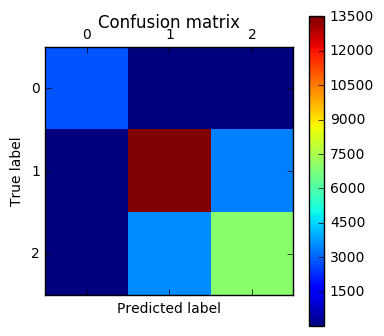

In [191]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

#### Less improvement than leaving formation in, but a fraction of a percent (0.08%) better than the basic model

### Throw the kitchen sink at the data and see if any other models show promise

In [3]:
names = [
    "Nearest Neighbors", 
    "Linear SVM", 
    #"RBF SVM", 
    #"Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net", 
    "AdaBoost",
    "Naive Bayes", 
    "QDA", 
    "Gradient Boosting", 
    "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    GradientBoostingClassifier(),
    LogisticRegression()]


In [4]:
def get_scores(model, X_train, X_test, y_train, y_test, labels):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict, average='weighted', labels=labels), \
           recall_score(y_test, y_predict, average='weighted', labels=labels)

In [10]:
# prep the data
pbp = prep(pbp_train_raw.copy())

# split the class from the values
y = pbp['Play']
X = pbp.drop(['Play'], axis=1).values

# save a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [11]:
#print gbc.classes_
labels = ['KICK', 'PASS', 'RUSH']

In [12]:
# try out each of the classifiers
for name, clf in zip(names, classifiers):
    print name, ":", get_scores(clf, X_train, X_test, y_train, y_test, labels)

Nearest Neighbors : (0.61435390946502055, 0.61175918336192536, 0.61435390946502055)
Linear SVM : (0.75845267489711932, 0.76109746949409385, 0.75845267489711932)
Decision Tree : (0.76111934156378602, 0.76084891169251845, 0.76111934156378602)
Random Forest : (0.63940740740740742, 0.6744484222482392, 0.63940740740740742)
Neural Net : (0.75545679012345679, 0.76463056672255336, 0.75545679012345679)
AdaBoost : (0.73527572016460907, 0.73277847768683679, 0.73527572016460907)
Naive Bayes : (0.69659259259259254, 0.69878651384999224, 0.69659259259259254)
QDA :

/Users/zgreyn/.local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:694: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


 (0.64483950617283947, 0.77238414772099007, 0.64483950617283947)
Gradient Boosting : (0.76628806584362141, 0.76617421290936849, 0.76628806584362141)
Logistic Regression : (0.75621399176954729, 0.75502222772245453, 0.75621399176954729)
